# Testing pruning methods

In this notebook, we will test the pruning methods. We have assumed that we will decouple the structure discovery problem into finding the order and then using a post-processing module to figure out the actual underlying graph via pruning. Therefore, this notebook assumes we have a correct causal ordering and will try to move further on using that baseline.

In this notebook, we will work with one of the `bnlearn` datasets and perform a topological ordering on the actual graph to obtain a correct causal ordering. To do so, customize the dataset that you intend to work on in the following:

In [1]:
DATASET_NAME = 'alarm' # You can set it to 'sachs', 'alarm', 'asia' or any other bnlearn datasets

Now use the following to generate a set of samples from the dataset of choice. This will use the code in the datamodule.

In [2]:
import sys
sys.path.append('..')

# setup data
from ocd.data import CausalDataModule
import dycode
import torch

dycode.register_context(torch)

dm = CausalDataModule(
    name=DATASET_NAME,  # small dataset asia
    observation_size=4096,  # number of observation samples
    intervention_size=0,  # set to 0 for no intervention
    batch_size=128,
    num_workers=0,  # set to 0 for no multiprocessing
    val_size=0,  # 10% of data for validation, or use int for exact number of samples, set to 0 for no validation
)
dm.setup("fit")



[bnlearn] >Import <alarm>
[bnlearn] >Loading bif file </home/hamidreza/Work/myprojects/ocd/venv/lib/python3.10/site-packages/bnlearn/data/alarm.bif>
[bnlearn] >Check whether CPDs sum up to one.
[bnlearn] >CPD [BP] does not add up to 1 but is: [[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]
[bnlearn] >CPD [HREKG] does not add up to 1 but is: [[0.9999999 0.9999999 1.       ]
 [0.9999999 1.        1.       ]]
[bnlearn] >CPD [HRSAT] does not add up to 1 but is: [[0.9999999 0.9999999 1.       ]
 [0.9999999 1.        1.       ]]
[bnlearn] >CPD [PRESS] does not add up to 1 but is: [[[1. 1. 1. 1.]
  [1. 1. 1. 1.]]

 [[1. 1. 1. 1.]
  [1. 1. 1. 1.]]

 [[1. 1. 1. 1.]
  [1. 1. 1. 1.]]]
[bnlearn] >Check whether CPDs associated with the nodes are consistent: True


Run the following piece of code to plot the actual underlying structure as a DAG.

[bnlearn] >Import <alarm>
[bnlearn] >Loading bif file </home/hamidreza/Work/myprojects/ocd/venv/lib/python3.10/site-packages/bnlearn/data/alarm.bif>
[bnlearn] >Check whether CPDs sum up to one.
[bnlearn] >CPD [BP] does not add up to 1 but is: [[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]
[bnlearn] >CPD [HREKG] does not add up to 1 but is: [[0.9999999 0.9999999 1.       ]
 [0.9999999 1.        1.       ]]
[bnlearn] >CPD [HRSAT] does not add up to 1 but is: [[0.9999999 0.9999999 1.       ]
 [0.9999999 1.        1.       ]]
[bnlearn] >CPD [PRESS] does not add up to 1 but is: [[[1. 1. 1. 1.]
  [1. 1. 1. 1.]]

 [[1. 1. 1. 1.]
  [1. 1. 1. 1.]]

 [[1. 1. 1. 1.]
  [1. 1. 1. 1.]]]
[bnlearn] >Check whether CPDs associated with the nodes are consistent: True
[bnlearn] >Set node properties.
[bnlearn] >Set edge properties.
[bnlearn] >Plot based on Bayesian model


{'ax': <Figure size 1500x1000 with 1 Axes>,
 'pos': {'LVFAILURE': array([-0.12081498, -0.02906978]),
  'HISTORY': array([-0.68796596,  0.40026708]),
  'LVEDVOLUME': array([ 0.7222226 , -0.12313669]),
  'CVP': array([0.82751596, 0.30693342]),
  'PCWP': array([ 0.60882216, -0.54974499]),
  'HYPOVOLEMIA': array([ 0.05365648, -0.26255432]),
  'STROKEVOLUME': array([-0.61703757, -0.39543363]),
  'ERRLOWOUTPUT': array([ 0.66823225, -0.0217839 ]),
  'HRBP': array([ 0.90852595, -0.08980723]),
  'HR': array([0.10462229, 0.03602954]),
  'ERRCAUTER': array([0.04731268, 0.16198133]),
  'HREKG': array([-0.13699348, -0.67906652]),
  'HRSAT': array([0.23601927, 1.        ]),
  'ANAPHYLAXIS': array([-0.23933821, -0.12142396]),
  'TPR': array([-0.27326587, -0.17044564]),
  'ARTCO2': array([ 0.15364681, -0.36212095]),
  'EXPCO2': array([ 0.14549738, -0.74156168]),
  'VENTLUNG': array([-0.10272638, -0.03240329]),
  'INTUBATION': array([-0.22201311,  0.17657272]),
  'MINVOL': array([-0.47790604,  0.670564

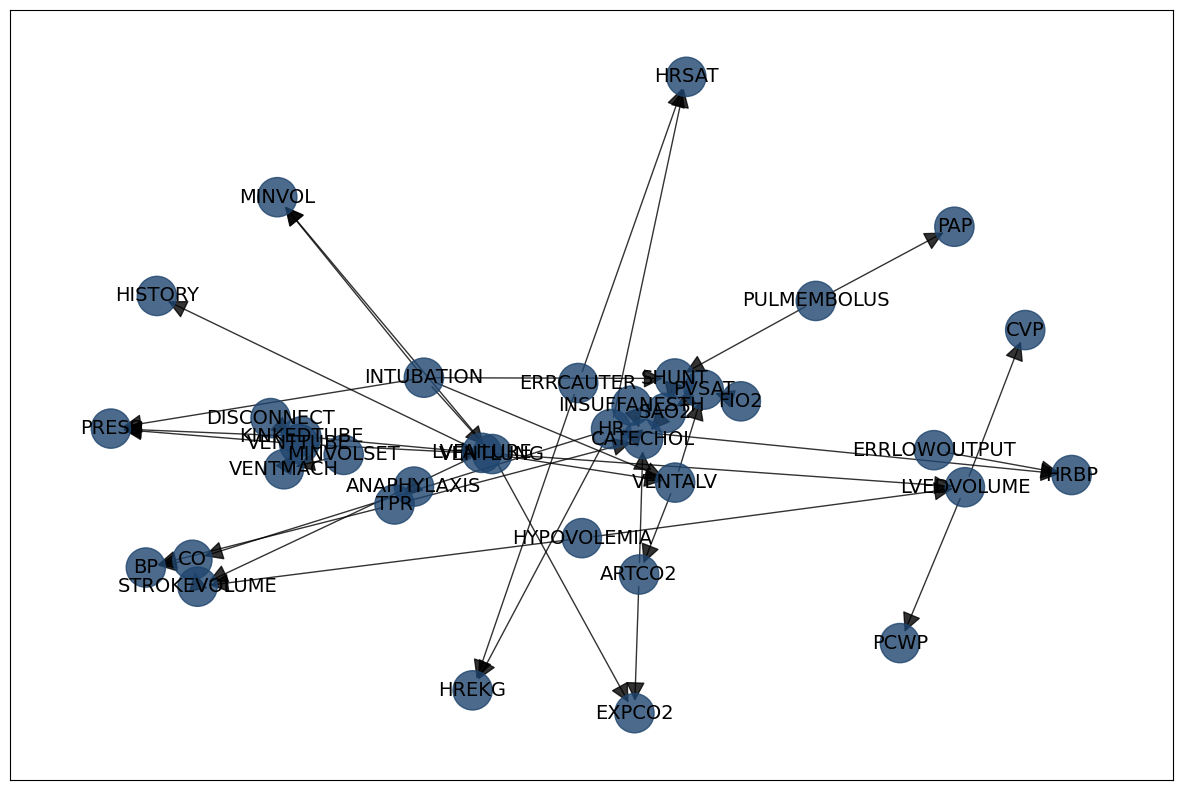

In [3]:
import bnlearn as bn

bn.plot(bn.import_DAG(DATASET_NAME))

Run the following piece of code to obtain a set of observational samples from the causal structure. You can also obtain the dataframe from the datamodule that has already been created. Simply choose which dataframe to go for.

In [4]:
import bnlearn as bn
resp = input('Use datamodule? (y/n) ')
if resp == 'y':
    df = dm.datasets[0].samples
else:
    df = bn.import_example(DATASET_NAME)
    df = df.reindex(sorted(df.columns), axis=1)

[bnlearn] >Extracting files..


Run the following to obtain the correct causal ordering by a simple topological sort algorithm on the ground truth DAG. Note that there might be multiple correct causal orderings, therefore, you can specify a `seed` parameter that will randomize the process of getting the causal ordering. That way, you can obtain multiple orderings by tuning `seed`. That being said, a good pruning method should be oblivious to the causal ordering as long as it is a correct topological ordering of the ground truth DAG.

In [5]:
import random

# Set the seed of interest
random.seed(121)

# do a topological ordering on the DAG dm.datasets[0].dag
# then use that index to reorder the columns
# implement topological ordering from scratch
def dfs(node, adj, stack, visited):
    visited[node] = True
    # Create a permuted list of indices from 0 to len(adj)
    idx = list(range(len(adj)))
    random.shuffle(idx)
    for i in idx:
        if adj[node][i] and not visited[i]:
            dfs(i, adj, stack, visited)
    stack.append(node)

def topological_sort(adj):
    stack = []
    visited = [False] * len(adj)
    for i in range(len(adj)):
        if not visited[i]:
            dfs(i, adj, stack, visited)
    # invert the stack
    return stack[::-1]


topol_sorted = topological_sort(dm.datasets[0].dag)
print("The indices of the topoligical ordering")
print(topol_sorted)
col_names = []
for i in topol_sorted:
    col_names.append(dm.datasets[0].samples.columns[i])
print("The column names of the topological ordering (To check with the figure)")
print(col_names)

The indices of the topoligical ordering
[27, 24, 23, 35, 21, 19, 18, 30, 17, 16, 20, 25, 31, 11, 10, 8, 7, 6, 36, 34, 33, 28, 29, 22, 26, 5, 1, 9, 0, 32, 3, 12, 4, 2, 15, 13, 14]
The column names of the topological ordering (To check with the figure)
['PULMEMBOLUS', 'PAP', 'MINVOLSET', 'VENTMACH', 'LVFAILURE', 'KINKEDTUBE', 'INTUBATION', 'SHUNT', 'INSUFFANESTH', 'HYPOVOLEMIA', 'LVEDVOLUME', 'PCWP', 'STROKEVOLUME', 'HISTORY', 'FIO2', 'ERRLOWOUTPUT', 'ERRCAUTER', 'DISCONNECT', 'VENTTUBE', 'VENTLUNG', 'VENTALV', 'PVSAT', 'SAO2', 'MINVOL', 'PRESS', 'CVP', 'ARTCO2', 'EXPCO2', 'ANAPHYLAXIS', 'TPR', 'CATECHOL', 'HR', 'CO', 'BP', 'HRSAT', 'HRBP', 'HREKG']


Using the correct topological ordering, the following will perform a test on the prune function from `ocd.post_preocessing.pruning.prune`. You can also set an input DAG for the pruning method.

The method will obtain a `pruned_dag` and will compare it with the ground truth one in terms of structural hamming distance.

**Note**: An important test would be to give the ground truth DAG as an initializiation DAG. The method should not prune anything ideally and should simply return the whole DAG again.

In [6]:
%load_ext autoreload

In [7]:
%autoreload 2

from ocd.post_processing.pruning import prune
from ocd.post_processing.pruning import PruningMethod
from ocd.evaluation import shd

import numpy as np
ground_truth = dm.datasets[0].dag
pruned_dag = prune(topol_sorted, df, PruningMethod.CONDITIONAL_INDEPENDENCE_TESTING,
            # dag=ground_truth,
            verbose=1,
            method_params={
                'threshold': 0.02,
            }
            )

# Uncomment if you want to see the pruned DAG and the ground truth
# print(pruned_dag)
# print(ground_truth)

print("The number of edges in the original DAG is: ", np.sum(ground_truth).astype(int))
print("Structural hamming distance between pruned_dag and original_dag is: ", shd(pruned_dag, ground_truth))

100%|██████████| 37/37 [01:11<00:00,  1.93s/it]

The number of edges in the original DAG is:  46
Structural hamming distance between pruned_dag and original_dag is:  22
